In [1]:
import os, sys
import glob

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image, ImageFilter, ImageChops

from skimage import io, img_as_float
import base64

import matplotlib
from matplotlib import cm
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

from scipy.stats import entropy
from collections import Counter

from IPython.display import clear_output
import importlib
import time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### set up paths

In [59]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
stimuli_dir = os.path.join(proj_dir,'stimuli')
datavol_dir = '/data/datasets/semantic_mapping' ## path to data on nightingale
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,results_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,results_dir,'gallery'))
map_dir = os.path.abspath(os.path.join(proj_dir,results_dir,'maps'))
utils_dir = os.path.join(proj_dir,'utils')
mask_dir = os.path.join(utils_dir, 'object_masks')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
    
import utils as u
import socket

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(i) for i in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir, mask_dir]]

## import dictionaries that map between shapenet ids and graphical conventions naming scheme
importlib.reload(u)
G2S = u.GC2SHAPENET
S2G = u.SHAPENET2GC

### load in metadata

In [60]:
## paths to sketch and object maps
sketch_map_dir = os.path.join(map_dir, 'single_sketch_maps')
object_map_dir = os.path.join(map_dir, 'target_object_maps')

## construct metadata object for sketch maps
sketch_map_fnames = sorted(os.listdir(sketch_map_dir))
S = pd.DataFrame(sketch_map_fnames)
S.columns = ['filename']
S = S.assign(path = S.apply(lambda x: os.path.join(sketch_map_dir, x['filename']), axis=1))
S = S.assign(gameID = S.apply(lambda x: x['filename'].split('_')[0], axis=1))
S = S.assign(target_id = (S.apply(lambda x: '{}_{}'
                               .format(x['filename']
                                       .split('_')[1], x['filename']
                                       .split('_')[2]), axis=1)))
S = S.assign(repetition = S.apply(lambda x: int(str(x['filename'].split('_')[3].split('.')[0]).zfill(2)), axis=1))
S = S.assign(shapenet_id = S.apply(lambda x: G2S[x['target_id']], axis=1))
S = S.assign(gameID_target = S.apply(lambda x: '{}_{}'.format(x['gameID'], x['target_id']), axis=1))
S.sort_values(by=['gameID','target_id','repetition'], inplace=True)
print('There are {} annotated sketches.'.format(S.shape[0]))

## construct metadata object for target maps
object_map_fnames = sorted(os.listdir(object_map_dir))
O = pd.DataFrame(object_map_fnames)
O.columns = ['filename']
O = O.assign(target_id = O.apply(lambda x: x['filename'].split('.')[0], axis=1))
O = O.assign(shapenet_id = O.apply(lambda x: G2S[x['target_id']], axis=1))

## load in group metadata
path_to_meta = os.path.join(stimuli_dir,'graphical_conventions_group_data_run5_submitButton.csv')
M = pd.read_csv(path_to_meta)
M = M.assign(gameID_target = M.apply(lambda x: '{}_{}'.format(x['gameID'],  x['target']), axis=1))

## convenience dictionary to map from gameID/target combinations to condition labels
GT2C = dict(zip(M.gameID_target.values, M.condition.values))
## add condition column to S so we can easily subset on condition
S = S.assign(condition = S.apply(lambda x: GT2C[x['gameID_target']], axis=1))

There are 2600 annotated sketches.


## Compute diagnosticity of sketches over time

In [63]:
invalid_sketch_map_inds = []
missing_sketch_map_inds = []
counter = 1
sketch_map_intensity_tally = []
for name, group in M.groupby(['gameID','target','repetition']):

    assert len(group.index)==1
    print('{} | Now computing diagnosticity for: {} {} {}'.format(counter,name[0], name[1], name[2]))
    clear_output(wait=True)
    counter+=1
    
    ## grab the corresponding row of the dataframe
    s = S[(S['gameID']==name[0]) & (S['target_id']==name[1]) & (S['repetition']==name[2])]
    o = O[O['target_id']==name[1]]
    
    ## only proceed if there is an annotated sketch here
    if s.shape[0]!=1:
        missing_sketch_map_inds.append(group.index[0])
    else:
        ## get path to load in raw mappings
        sketch_map_path = os.path.join(sketch_map_dir, s['filename'].values[0])
        object_map_path = os.path.join(object_map_dir, o['filename'].values[0])            
        mask_path = os.path.join(mask_dir, '{}-mask.png'.format(s['target_id'].values[0]))
        
        ## load in images 
        sketch_map = Image.open(sketch_map_path).convert('L')
        object_map = Image.open(object_map_path).convert('L')
        object_mask = Image.open(mask_path).resize((300,300),Image.LANCZOS)
        sketch_map_intensity_tally.append(np.mean(sketch_map))
        
        if np.mean(sketch_map) < 1: ## check if invalid/empty sketch map; only proceed if valid, non-empty map
            invalid_sketch_map_inds.append(group.index[0])
        else:
            ## multiply sketch and object maps together
            combo_array = np.array(sketch_map).astype(np.float32) * np.array(object_map).astype(np.float32) / 255
            sketch_object_combo = Image.fromarray(combo_array.astype(np.uint16)).convert('L')      
#             sketch_object_combo = ImageChops.multiply(sketch_map,object_map)
            
            ## multiply sketchxobject and object MASK together
            masked_combo_array = combo_array * object_mask / 255
            masked_combo = Image.fromarray(masked_combo_array.astype(np.uint16)).convert('L')               
                    
            ## save out convolved object x sketch maps
            out_dir = os.path.join(map_dir,'object_sketch_maps')
            if not os.path.exists(out_dir):
                os.makedirs(out_dir) 
            out_path = os.path.join(out_dir,'{}_{}_{}.png'.format(name[0], name[1], str(name[2]).zfill(2)))
            masked_combo.save(out_path)    

            ## total intensity of sketch_map, normalize diagnosticity by this
            sketch_map_total_intensity = np.sum(sketch_map)/255
            M.loc[group.index[0],'intensity'] = sketch_map_total_intensity             

            ## compute raw sketch diagnosticity
            sketch_diagnosticity = np.sum(masked_combo)/255
            M.loc[group.index[0],'diagnosticity_raw'] = sketch_diagnosticity             
            
            ## compute normalized sketch diagnosticity
            sketch_diagnosticity = np.sum(masked_combo)/255/sketch_map_total_intensity
            M.loc[group.index[0],'diagnosticity'] = sketch_diagnosticity 
            
            ## compute entropy of sketch-object composite
            sketch_entropy = entropy(np.array(masked_combo).flatten())
            M.loc[group.index[0],'entropy'] = sketch_entropy 

print('Done!')

Done!


In [64]:
## save out invalid sketch map inds so that we can collect higher quality maps on them
M.iloc[invalid_sketch_map_inds].to_csv(os.path.join(csv_dir,'invalid_stroke_maps.csv'),index=False)

In [65]:
print('{} invalid/blank sketch maps'.format(len(invalid_sketch_map_inds)))
print('{} missing sketch maps'.format(len(missing_sketch_map_inds)))

3 invalid/blank sketch maps
0 missing sketch maps


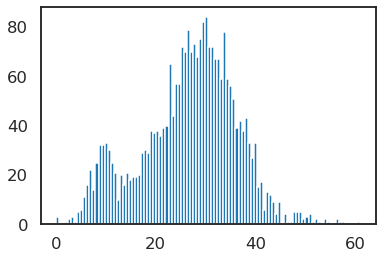

In [66]:
h = plt.hist(sketch_map_intensity_tally,bins=100)

### save out diagnosticity tidy dataframe

In [67]:
M.to_csv(os.path.join(csv_dir,'graphical_conventions_group_data_run5_submitButton_diagnosticity.csv'),index=False)

### quick diagnosticity analyses & plots 

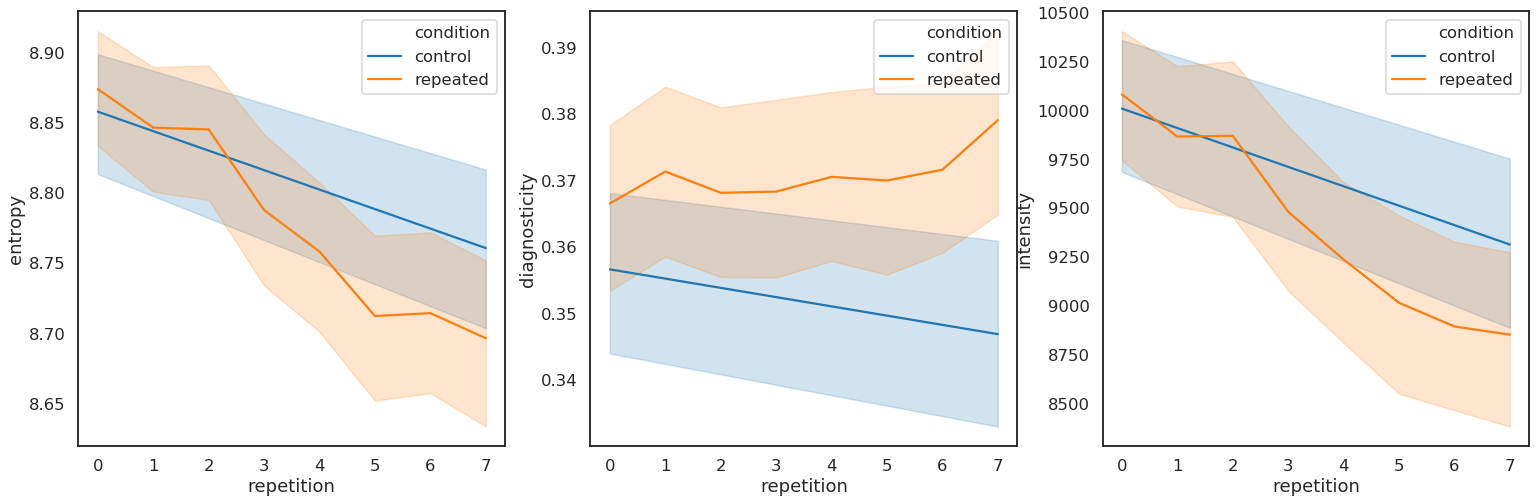

In [68]:
fig = plt.figure(figsize=(26,8))
plt.subplot(131)
sns.lineplot(data=M, x='repetition', y='entropy', hue='condition')
plt.subplot(132)
sns.lineplot(data=M, x='repetition', y='diagnosticity', hue='condition')
plt.subplot(133)
sns.lineplot(data=M, x='repetition', y='intensity', hue='condition')

## Compute IOU (intersection over union) for each pair of sketches

In [61]:
## get all combinations
num_reps = 8 
mesh = np.array(np.meshgrid(np.arange(num_reps), np.arange(num_reps)))
combos = mesh.T.reshape(-1, 2)

## subset to just repeated condition
SR = S[S['condition']=='repeated']

## init XSECT & YSECT group heatmaps
XSECT = [] # diagnosticity of what is shared between sketches (intersection)
YSECT = [] # diagnosticity of what is lost between early and late sketches (setdiff)
counter = 1

## init group dataframe
I2 = pd.DataFrame()

for name, group in SR.groupby(['gameID', 'target_id']):
    if SR[SR['gameID']==name[0]].shape[0]==32: ## only analyze those that we have complete annotations for
        print('{} | Analyzing {} {}'.format(counter, name[0], name[1]))
        counter +=1
        clear_output(wait=True)
        I = pd.DataFrame()
        I['arr1']=None
        I['arr2']=None
        I['xsect']=None
        I['xsect_obj']=None
        I['union']=None    
        I['im1not2']=None
        I['im1not2_obj'] = None
        I['im2not1']=None

        sid = group['target_id'].unique()[0]

        ## extract object map (ground truth diagnosticity for this object)
        obj_path = os.path.join(object_map_dir,'{}.png'.format(sid))
        obj_map = np.array(Image.open(obj_path)).astype(np.float32).flatten()    

        for combo_ind, this_combo in enumerate(combos):

            ## unique identifier for each gameID/target combo
            I.loc[combo_ind, 'obj_id'] = group['gameID_target'].unique()[0]    
            I.loc[combo_ind, 'im1_index'] = np.int(this_combo[0])
            I.loc[combo_ind, 'im2_index'] = np.int(this_combo[1])

            im1_path = group.iloc[this_combo[0]]['path']
            im2_path = group.iloc[this_combo[1]]['path']

            im1 = Image.open(im1_path)
            im2 = Image.open(im2_path)

            arr1 = np.array(im1).flatten()
            arr2 = np.array(im2).flatten()
            I.at[combo_ind,'arr1'] = arr1
            I.at[combo_ind,'arr2'] = arr2
            I.loc[combo_ind,'arr1_size'] = np.sum(arr1)
            I.loc[combo_ind,'arr2_size'] = np.sum(arr2)        
            ## get individual diagnosticity
            arr1_obj = (obj_map * arr1) / 255
            arr2_obj = (obj_map * arr2) / 255
            arr1_total = np.sum(arr1)
            arr2_total = np.sum(arr2)
            I.loc[combo_ind,'arr1_obj_diagnosticity'] = np.sum(arr1_obj)/arr1_total
            I.loc[combo_ind,'arr2_obj_diagnosticity'] = np.sum(arr2_obj)/arr2_total
            I.loc[combo_ind,'diagnosticity_change'] = np.sum(arr2_obj)/arr2_total - np.sum(arr1_obj)/arr1_total

            ## get intersection (sketch content in im2 that is also in im1)
            xsect = np.logical_and(arr1, arr2)
            I.at[combo_ind,'xsect'] = xsect
            I.loc[combo_ind,'xsect_size'] = np.sum(xsect)  

            ## get union (sketch content in either im1 or im2)
            union = np.logical_or(arr1, arr2)
            I.at[combo_ind,'union'] = xsect
            I.loc[combo_ind,'union_size'] = np.sum(union)         
                        
            ## get insersection x object diagnosticity map
#             xsect_obj = (obj_map * xsect) / 255
#             I.at[combo_ind,'xsect_diagnosticity'] = xsect_obj        
#             I.loc[combo_ind,'xsect_diagnosticity_sum'] = np.sum(xsect_obj)            

            ## get inverse of each image
            inv1 = np.invert(arr1)
            inv2 = np.invert(arr2)

            ## get A-not-B set diff (sketch content in im1 that no longer appears in im2)
            im1not2 = np.logical_and(arr1, inv2)
            I.at[combo_ind,'im1not2'] = im1not2
            I.loc[combo_ind,'im1not2_size']  = np.sum(im1not2)

            ## get A-not-B x object diagnosticity map
#             im1not2_obj = (obj_map * im1not2) / 255
#             I.at[combo_ind,'im1not2_obj'] = im1not2_obj        
#             I.loc[combo_ind,'im1not2_obj_sum'] = np.sum(im1not2_obj)     

            ## get B-not-A set diff (new sketch content that appears in im2 that was not in im1)
            im2not1 = np.logical_and(arr2, inv1)
            I.at[combo_ind,'im2not1'] = im2not1
            I.loc[combo_ind,'im2not1_size']  = np.sum(im2not1)

            ## get IOU (intersection over union)
            I.loc[combo_ind,'IOU'] = I.loc[combo_ind, 'xsect_size'] / I.loc[combo_ind, 'union_size']
            I.loc[combo_ind,'AOU'] = I.loc[combo_ind, 'im1not2_size'] / I.loc[combo_ind, 'union_size']
            I.loc[combo_ind,'BOU'] = I.loc[combo_ind, 'im2not1_size'] / I.loc[combo_ind, 'union_size']

        I = (I.astype({'im1_index': 'int32', 'im2_index': 'int32', 'xsect_size':'int32',
                        'im1not2_size': 'int32', 'im2not1_size': 'int32',
                        'arr1_size': 'int32', 'arr2_size': 'int32', 'union_size': 'int32'}))    

        ## create intersection heatmap
#         X = np.zeros((num_reps,num_reps)) ## init d matrix 
#         for i,d in I.iterrows():
#             if (d['arr1_size']==0) or (d['arr2_size']==0) or (d['xsect_size']==0):
#                 X[d['im1_index'], d['im2_index']] = np.nan
#             else:
#                 X[d['im1_index'], d['im2_index']] = d['xsect_obj_sum'] / d['xsect_size']        
#         XSECT.append(X)

        ## create A-not-B set-diff heatmap
#         Y = np.zeros((num_reps,num_reps)) ## init d matrix 
#         for i,d in I.iterrows():
#             if (d['arr1_size']==0) or (d['arr2_size']==0) or (d['im1not2_size']==0):
#                 Y[d['im1_index'], d['im2_index']] = np.nan
#             else:
#                 Y[d['im1_index'], d['im2_index']] = d['im1not2_obj_sum'] / d['im1not2_size']        
#         YSECT.append(Y)  

        ## get aggregate dataframe for whole group
        if len(I2) == 0:
            I2 = I
        else:
            I2 = pd.concat([I2, I], axis=0)


## convert to numpy array
# XSECT = np.array(XSECT) 
# YSECT = np.array(YSECT) 
I2 = I2.reset_index(drop=True)
print('Done!')

Done!


In [62]:
fname = 'graphical_conventions_group_data_run5_submitButton_sketchOverlap.csv'
I2[['obj_id', 'diagnosticity_change', 'IOU', 'AOU', 'BOU']].to_csv(os.path.join(csv_dir,'diagnosticity.csv'),index=False,)

### Visualize mean diagnosticity for four cases:

- (1) whole sketches across repetitions 
- (2) partial sketches that are shared between pairs of sketches (intersection btw A & B)
- (3) partial sketches that appear in early sketches but NOT in later ones (A not B)
- (4) partial sketches that appear in late sketches but NOT in early ones (B not A)

**Case 1: whole sketches across repetitions**
    - the diagonal of this matrix
**Case 2: partial sketches that are shared between pairs of sketches (intersection btw A & B)**
    - the off-diagonal cells. 
    - from left to right, row 1 shows how mean diagnosticity of intersection between first sketch and subsequent sketches evolves across repetitions
    - the parts of later sketches that are shared with early sketches are higher in diagnosticity than the parts of earlier sketches shared with even earlier sketches

In [ ]:
plt.matshow(np.nanmean(XSECT,axis=0), cmap='viridis') #, vmin=0.3, vmax=0.45
plt.colorbar()

**Case 3: partial sketches that appear in early sketches but NOT in later ones (A not B)**
    - the upper triangle of this matrix
    - from left to right, row 1 shows how mean diagnosticity of parts of sketches that "drop out" after 1st sketch evolves across repetitions    
**Case 4: partial sketches that appear in late sketches but NOT in early ones (B not A)**
    - the lower triangle of this matrix
    - from top to bottom, column 1 shows how mean diagnosticity of parts of sketches that "pop up" after 1st sketch (but do NOT appear in 1st sketch) evolves across repetitions

In [ ]:
plt.matshow(np.nanmean(YSECT,axis=0), cmap='viridis') #, vmin=0.3, vmax=0.45
plt.colorbar()

In [ ]:
plt.plot(np.nanmean(XSECT,axis=0)[0], color=(0.8,0.2,0.2))
plt.plot(np.diag(np.nanmean(XSECT,axis=0)), color=(0.2,0.8,0.2))
plt.plot(np.nanmean(YSECT,axis=0)[0], color=(0.2,0.2,0.8))

### save these results to be analyzed in R (random intercepts for targets, gameIDs)

In [ ]:
## just pick the columns that aren't huge (i.e., that aren't image arrays)
I3 = (I2[['obj_id', 'im1_index', 'im2_index', 'arr1_size', 'arr2_size', 'xsect_size',
          'xsect_obj_sum', 'union_size','im1not2_size','im1not2_obj_sum', 'im2not1_size']])

## save out
out_path = os.path.join(csv_dir, 'paired_sketch_diagnosticity_repeated.csv')
I3.to_csv(out_path, index=False)

### look at aggregate sketch diagnosticity map instead of individual sketches

In [ ]:
targetRep_sketch_dir = os.path.join(map_dir, 'targetRep_sketch_maps')
targetRep_maps = glob.glob(os.path.join(targetRep_sketch_dir, '*'))

In [ ]:
TR = pd.DataFrame(targetRep_maps)
TR.columns = ['path']
TR = TR.assign(filename = TR.apply(lambda x: x['path'].split('/')[-1], axis=1))
TR = TR.assign(target_id = TR.apply(lambda x: '{}_{}'.format(x['filename'].split('_')[0], x['filename'].split('_')[1]), axis=1))
TR = TR.assign(repetition = TR.apply(lambda x: x['filename'].split('_')[-1].split('.')[0], axis=1))
TR['repetition_numeric'] = pd.to_numeric(TR['repetition'])

In [ ]:
for i,d in TR.iterrows():
    print('{} | Analyzing {} {}'.format(i+1, d['target_id'], d['repetition']))
    clear_output(wait=True)
    
    ## get path to load in raw mappings
    sketch_map_path = d['path']
    object_map_path = os.path.join(object_map_dir, O[O['target_id']==d['target_id']]['filename'].values[0])            

    ## load in images 
    sketch_map = Image.open(sketch_map_path).convert('L')
    object_map = Image.open(object_map_path).convert('L')

    ## multiply images together
    combo_array = np.array(sketch_map).astype(np.float32) * np.array(object_map).astype(np.float32) / 255
    sketch_object_combo = Image.fromarray(combo_array.astype(np.uint16)).convert('L')    
#     sketch_object_combo = ImageChops.multiply(sketch_map,object_map)

    ## save out convolved object x sketch maps
    out_dir = os.path.join(map_dir,'object_sketch_maps_aggregate')
    if not os.path.exists(out_dir):
        os.makedirs(out_dir) 
    out_path = os.path.join(out_dir,'{}_{}.png'.format(d['target_id'], d['repetition']))
    sketch_object_combo.save(out_path)    

    ## total intensity of sketch_map, normalize diagnosticity by this
    sketch_map_total_intensity = np.sum(sketch_map)/255
    TR.loc[i,'intensity'] = sketch_map_total_intensity             

    ## compute raw sketch diagnosticity
    sketch_diagnosticity = np.sum(sketch_object_combo)/255
    TR.loc[i,'diagnosticity_raw'] = sketch_diagnosticity             

    ## compute normalized sketch diagnosticity
    sketch_diagnosticity = np.sum(sketch_object_combo)/255/sketch_map_total_intensity
    TR.loc[i,'diagnosticity'] = sketch_diagnosticity 

    ## compute entropy of sketch-object composite
    sketch_entropy = entropy(np.array(sketch_object_combo).flatten())
    TR.loc[i,'entropy'] = sketch_entropy 
    
print('Done!')

In [ ]:
sketch_map

In [ ]:
object_map

In [ ]:
ImageChops.multiply(sketch_map,object_map)

In [ ]:
sns.heatmap(np.array(sketch_map).astype(np.float32))

In [ ]:
sns.lineplot(data=TR, 
             x='repetition_numeric',
             y='diagnosticity',
             hue='target_id')
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
sns.lineplot(data=TR, 
             x='repetition_numeric',
             y='diagnosticity')
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
TR